In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import sklearn.metrics as metrics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Stack_questions_cleaned.csv',sep=';')

In [5]:
from ast import literal_eval
for col in ['Title', 'Body', 'Tags', 'text_comb']:
     data[col] = data[col].apply(literal_eval)

In [6]:
data.head()

,Title,Body,Tags,text_comb
0,"[comma, array, print, bracket]","[fit, console, game, original, format, comma, ...","[array, android, java]","[fit, console, game, original, format, comma, ..."
1,"[directory, c, listing]","[scan, c, file, folder, platform, cross, direc...","[c, file]","[scan, c, file, folder, platform, cross, direc..."
2,"[return, wcf, datatables]","[table, underlie, timeouts, data, connection, ...","[c#, service]","[table, underlie, timeouts, data, connection, ..."
3,"[error, visible, element]","[demo, count, tesstcase, error, syntaxerror, e...",[javascript],"[demo, count, tesstcase, error, syntaxerror, e..."
4,"[resolution, opencv, camera, increase, capture]","[webcam, resolution, opencv, quickcam, c++, im...","[c, image]","[webcam, resolution, opencv, quickcam, c++, im..."


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [8]:
%%time
# Define X and y
X = data["text_comb"]
y = data["Tags"]

# Initialize the "CountVectorizer" TFIDF for text_comb
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.95,
                             min_df= 5,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)
vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X for Full_doc: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print(f"Shape of y:              {y_binarized.shape}")

Shape of X for Full_doc: (19117, 6616)
Shape of y:              (19117, 50)
CPU times: user 1.23 s, sys: 19.4 ms, total: 1.25 s
Wall time: 1.27 s


In [9]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.25, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (14337, 6616)
X_test shape : (4780, 6616)
y_train shape : (14337, 50)
y_test shape : (4780, 50)


In [10]:
from sklearn.metrics import average_precision_score, roc_auc_score
def metrics_report(model_name ,test_labels, y_score, df):    
    if(df is not None):
        temp_df = df
    else:
        #temp_df = pd.DataFrame(index=["Accuracy", "F1","Jaccard", "Recall","Precision"],columns=[model_name])
        temp_df = pd.DataFrame(index=["Av_precision(macro)","Av_precision(micro)","ROC_AUC(macro)",\
                                      "ROC_AUC(micro)"],columns=[model_name])
        
    scores = []
    scores.append(average_precision_score(test_labels, y_score,average='macro'))
    scores.append(average_precision_score(test_labels, y_score,average='micro'))
    scores.append(roc_auc_score(test_labels, y_score, multi_class="ovr" ,average='macro'))
    scores.append(roc_auc_score(test_labels, y_score, multi_class="ovr" ,average='micro'))
    temp_df[model_name] = scores
    
    return temp_df

In [11]:
from sklearn.metrics import roc_curve
def cut_off(y_test,y_score):
  n = y_score.shape[1]
  thresholds = np.zeros(n)
  # Compute fpr, tpr, thresholds and roc auc
  for j in range(n):
     # calculate roc curves
     fpr, tpr, ths = roc_curve(y_test[:,j], y_score[:,j])
     # calculate the statistic 
     #dis = np.sqrt(tpr**2+(1-fpr)**2)
     dis = abs(1-fpr-tpr)
     # locate the index of the lower distance
     idx = np.argmin(dis)
     thresholds[j] = ths[idx]
  threshold = thresholds.max() 
  
  return threshold

### Entrainement avec des approches supervisées

In [ ]:
%%time
reg_logit_clf = OneVsRestClassifier(LogisticRegression())
reg_logit_clf.fit(X_train, y_train)
#Prediction
reg_logit_pred = reg_logit_clf.predict_proba(X_test)
df_performance = metrics_report("reg_logit", y_test, reg_logit_pred, df=None)
print(df_performance)


                     reg_logit
Av_precision(macro)   0.688200
Av_precision(micro)   0.740364
ROC_AUC(macro)        0.969569
ROC_AUC(micro)        0.972379
CPU times: user 13.2 s, sys: 43.2 ms, total: 13.2 s
Wall time: 18.6 s


In [ ]:
cut_off(y_test,reg_logit_pred)

0.12326868889963911

In [ ]:
# Inverse transform
threshold = cut_off(y_test,reg_logit_pred)
reg_logit_preds = (reg_logit_pred>threshold)*1
y_pred_inversed = multilabel_binarizer.inverse_transform(reg_logit_preds)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*100)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 100)
print("Predicted:", y_pred_inversed[0:4])
print("True:", y_test_inversed[0:4])

----------------------------------------------------------------------------------------------------
Print 5 first predicted Tags vs true Tags
----------------------------------------------------------------------------------------------------
Predicted: [('android', 'java'), ('image', 'python'), ('php',), ('image', 'iphone')]
True: [('android', 'java'), ('algorithm', 'image', 'python'), ('c', 'iphone', 'objective', 'php'), ('c', 'objective')]


In [ ]:
%%time
knn_clf = OneVsRestClassifier(KNeighborsClassifier())
knn_clf.fit(X_train, y_train)

knn_preds = knn_clf.predict_proba(X_test)
df_performance = metrics_report("knn", y_test, knn_preds, df=df_performance)
print(df_performance)

                     reg_logit       knn
Av_precision(macro)   0.688200  0.455900
Av_precision(micro)   0.740364  0.496710
ROC_AUC(macro)        0.969569  0.857663
ROC_AUC(micro)        0.972379  0.876174
CPU times: user 2min 11s, sys: 1.41 s, total: 2min 12s
Wall time: 2min 12s


In [ ]:
# Inverse transform
threshold = cut_off(y_test,knn_preds)
y_pred_inversed = multilabel_binarizer.inverse_transform((knn_preds>threshold)*1)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*100)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 100)
print("Predicted:", y_pred_inversed[0:4])
print("True:", y_test_inversed[0:4])

----------------------------------------------------------------------------------------------------
Print 5 first predicted Tags vs true Tags
----------------------------------------------------------------------------------------------------
Predicted: [('android', 'design', 'java'), ('c#', 'google', 'image'), ('android',), ('c', 'iphone', 'objective')]
True: [('android', 'java'), ('algorithm', 'image', 'python'), ('c', 'iphone', 'objective', 'php'), ('c', 'objective')]


In [ ]:
%%time
clf_svm_lin = OneVsRestClassifier(SVC(kernel="linear",probability=True))
clf_svm_lin.fit(X_train, y_train)
svm_pred = clf_svm_lin.predict_proba(X_test)
df_performance = metrics_report("svm_linear", y_test, svm_pred, df=df_performance)
print(df_performance)

                     reg_logit       knn  svm_linear
Av_precision(macro)   0.688200  0.455900    0.681313
Av_precision(micro)   0.740364  0.496710    0.748174
ROC_AUC(macro)        0.969569  0.857663    0.944395
ROC_AUC(micro)        0.972379  0.876174    0.958580
CPU times: user 34min 4s, sys: 3.06 s, total: 34min 7s
Wall time: 34min


In [ ]:
threshold = cut_off(y_test, svm_pred)
print(threshold)

0.11007711384845355


In [ ]:
# Inverse transform
threshold = cut_off(y_test, svm_pred)
y_pred_inversed = multilabel_binarizer.inverse_transform((svm_pred>threshold)*1)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*100)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 100)
print("Predicted:", y_pred_inversed[0:4])
print("True:", y_test_inversed[0:4])

----------------------------------------------------------------------------------------------------
Print 5 first predicted Tags vs true Tags
----------------------------------------------------------------------------------------------------
Predicted: [('android', 'design', 'java', 'json'), ('image', 'python'), ('android', 'php'), ('c', 'image')]
True: [('android', 'java'), ('algorithm', 'image', 'python'), ('c', 'iphone', 'objective', 'php'), ('c', 'objective')]


In [ ]:
%%time
rf_clf = OneVsRestClassifier(RandomForestClassifier())
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict_proba(X_test)

df_performance = metrics_report("Random Forest", y_test, rf_preds, df=df_performance)
print(df_performance)

                     reg_logit       knn  svm_linear  Random Forest
Av_precision(macro)   0.688200  0.455900    0.681313       0.655079
Av_precision(micro)   0.740364  0.496710    0.748174       0.722733
ROC_AUC(macro)        0.969569  0.857663    0.944395       0.951162
ROC_AUC(micro)        0.972379  0.876174    0.958580       0.961582
CPU times: user 4min 58s, sys: 881 ms, total: 4min 59s
Wall time: 4min 58s


In [ ]:
# Inverse transform
threshold = cut_off(y_test,rf_preds)
y_pred_inversed = multilabel_binarizer.inverse_transform((rf_preds>threshold)*1)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*100)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 100)
print("Predicted:", y_pred_inversed[0:4])
print("True:", y_test_inversed[0:4])

----------------------------------------------------------------------------------------------------
Print 5 first predicted Tags vs true Tags
----------------------------------------------------------------------------------------------------
Predicted: [('android', 'java'), ('image', 'python'), ('php',), ('c', 'image', 'iphone', 'objective')]
True: [('android', 'java'), ('algorithm', 'image', 'python'), ('c', 'iphone', 'objective', 'php'), ('c', 'objective')]


In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = OneVsRestClassifier(GradientBoostingClassifier())
gb_clf.fit(X_train, y_train)
gb_preds = gb_clf.predict_proba(X_test)
df_performance = metrics_report("GradientBoosting", y_test, gb_preds, df=df_performance)
print(df_performance)

                     reg_logit       knn  svm_linear  Random Forest  \
Av_precision(macro)   0.688200  0.455900    0.681313       0.655079   
Av_precision(micro)   0.740364  0.496710    0.748174       0.722733   
ROC_AUC(macro)        0.969569  0.857663    0.944395       0.951162   
ROC_AUC(micro)        0.972379  0.876174    0.958580       0.961582   

                     GradientBoosting  
Av_precision(macro)          0.548410  
Av_precision(micro)          0.595988  
ROC_AUC(macro)               0.925750  
ROC_AUC(micro)               0.939244  
CPU times: user 11min 13s, sys: 30.6 s, total: 11min 43s
Wall time: 11min 41s


In [ ]:
# Inverse transform
threshold = cut_off(y_test,gb_preds)
y_pred_inversed = multilabel_binarizer.inverse_transform((gb_preds>threshold)*1)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*100)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 100)
print("Predicted:", y_pred_inversed[0:4])
print("True:", y_test_inversed[0:4])

----------------------------------------------------------------------------------------------------
Print 5 first predicted Tags vs true Tags
----------------------------------------------------------------------------------------------------
Predicted: [('android', 'java', 'json'), ('algorithm', 'c', 'image', 'python'), ('android', 'php', 'server'), ('c', 'image', 'iphone')]
True: [('android', 'java'), ('algorithm', 'image', 'python'), ('c', 'iphone', 'objective', 'php'), ('c', 'objective')]


In [ ]:
%%time 
param_rfc = {"estimator__n_estimators" : [300, 500], 
"estimator__max_depth" : [5, 10, 15],
}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            scoring="roc_auc_ovr",
                            verbose=3)
# Fit on Sample data
multi_rfc_cv.fit(X_train[0:5000], y_train[0:5000])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 3min 2s, sys: 2.27 s, total: 3min 4s
Wall time: 47min 56s


In [ ]:
rfc_cv_res = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("="*50)
print("Best params for RandomForestClassifier")
print("=" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

Best params for RandomForestClassifier
{'estimator__max_depth': 10, 'estimator__n_estimators': 500}


In [ ]:
rfo_clf = OneVsRestClassifier(RandomForestClassifier(max_depth=10, n_estimators=500))
rfo_clf.fit(X_train, y_train)
rfo_preds = rfo_clf.predict_proba(X_test)

In [ ]:
drf = pd.DataFrame(df_performance['Random Forest'], index = df_performance.index)
res = metrics_report("Random Forest(with Grids_cv)", y_test, rfo_preds, 
                     df=drf)
print(res)

                     Random Forest  Random Forest(with Grids_cv)
Av_precision(macro)       0.655079                      0.645258
Av_precision(micro)       0.722733                      0.617731
ROC_AUC(macro)            0.951162                      0.955859
ROC_AUC(micro)            0.961582                      0.935752


In [ ]:
rfo_clf = OneVsRestClassifier(RandomForestClassifier(min_samples_split=4, n_estimators=500))
rfo_clf.fit(X_train, y_train)
rfo_preds = rfo_clf.predict_proba(X_test)

In [ ]:
metrics_report("Random Forest", y_test, rfo_preds, df = None)

,Random Forest
Av_precision(macro),0.670562
Av_precision(micro),0.735456
ROC_AUC(macro),0.957763
ROC_AUC(micro),0.966517


### Modèle final choisi

Le choix du modèle final se basera essentiellement  sur les scores obtenus aux métriques. Nous prendrons également en compte le nombre de prédiction vide est le temps de simulation.

In [ ]:
results_perf = metrics_report("Random Forest", y_test, rfo_preds, df=df_performance)
print(results_perf.T)

                  Av_precision(macro)  Av_precision(micro)  ROC_AUC(macro)  \
reg_logit                    0.688200             0.740364        0.969569   
knn                          0.455900             0.496710        0.857663   
svm_linear                   0.681313             0.748174        0.944395   
Random Forest                0.670562             0.735456        0.957763   
GradientBoosting             0.548410             0.595988        0.925750   

                  ROC_AUC(micro)  
reg_logit               0.972379  
knn                     0.876174  
svm_linear              0.958580  
Random Forest           0.966517  
GradientBoosting        0.939244  


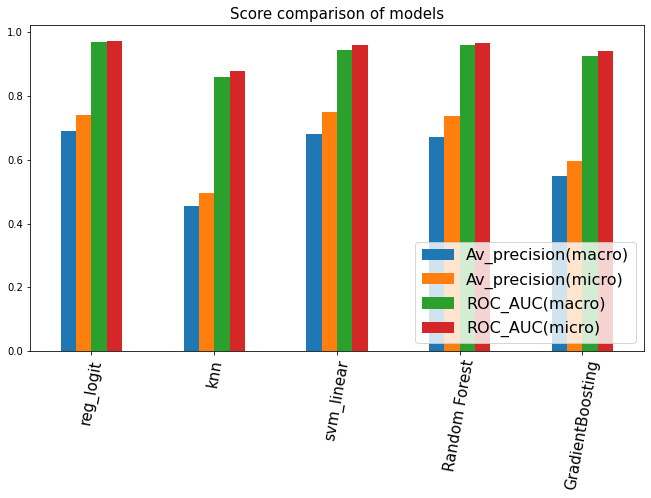

In [ ]:
ax = results_perf.T.plot.bar(figsize= (11,6));
ax.legend(loc=4,fontsize=16);
ax.set_xticklabels(results_perf.T.index,rotation=80, fontsize=15);
ax.set_title('Score comparison of models', fontsize=15);


In [ ]:
th_lr = cut_off(y_test,reg_logit_pred)
count_lr = sum(((reg_logit_pred>th_lr)*1).T)
th_rf = cut_off(y_test,rfo_preds)
count_rf= sum(((rfo_preds>th_rf)*1).T)
print('le nombre de prédiction vide de Regression Logistic est: ', sum(count_lr==0))
print('le nombre de prédiction vide de Random Forest est:       ', sum(count_rf==0))

le nombre de prédiction vide de Regression Logistic est:  150
le nombre de prédiction vide de Random Forest est:        242


### word2vec 

In [ ]:
from gensim.models import word2vec
#
model_w2v = word2vec.Word2Vec(data.text_comb, size=164, window=15, min_count=5, workers=4)
model_w2v.corpus_count

19117

In [ ]:
vocab = model_w2v.wv.vocab
list(vocab)[:6]

['fit', 'console', 'game', 'original', 'format', 'comma']

In [ ]:
model_w2v.wv.most_similar(['plot'])

[('matplotlib', 0.9490543603897095),
 ('contour', 0.92551589012146),
 ('matlab', 0.8974472880363464),
 ('axis', 0.8970696926116943),
 ('plotly', 0.8900080919265747),
 ('distance', 0.8880050778388977),
 ('scatter', 0.8758792877197266),
 ('histogram', 0.8682564496994019),
 ('shape', 0.8522722125053406),
 ('clockwise', 0.8521949052810669)]

In [ ]:
model_w2v.wv['java'].shape, model_w2v.wv['java'][:20]

((164,),
 array([ 0.2828135 ,  0.48405153,  0.98664343, -0.3936064 ,  1.2633514 ,
         0.28231844,  0.02234323,  0.7651835 ,  0.11972635, -0.7558276 ,
        -1.9596002 ,  0.8363636 ,  0.13744201, -0.7841936 , -0.00313314,
        -1.2064861 ,  0.287563  , -0.25950587,  0.08170132, -0.36447135],
       dtype=float32))

In [ ]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in model_w2v.wv.vocab]
    return np.sum(model_w2v.wv[doc], axis=0)

In [ ]:
%%time
# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(data.text_comb, y_binarized, test_size=0.2, random_state=42)
#
wv_train_feat = X_train.apply(document_vector)
wv_test_feat = X_test.apply(document_vector)
#
clf_lr = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
clf_lr.fit(list(wv_train_feat), y_train)
lr_pred = clf_lr.predict_proba(list(wv_test_feat))

CPU times: user 8min 55s, sys: 1min 6s, total: 10min 1s
Wall time: 5min 18s


In [ ]:
df_perf = metrics_report("reg_logit_wv", y_test, lr_pred, df=None)
print(df_perf)

                     reg_logit_wv
Av_precision(macro)      0.611024
Av_precision(micro)      0.707132
ROC_AUC(macro)           0.954562
ROC_AUC(micro)           0.964748


Le score de la précision moyenne de la régression logistique est nettement moindre que le score . Nous allons essayer de l'améliorer en jouant avec les hyperparamètres de l'apprentissage.

 ou réutiliser un model pré-entrainé significativement large et impliquannt un corpus similaire à notre jeu de données.

In [ ]:
size = [64, 128, 256, 400]
W =[5, 10, 15, 20]
sc1 = []
sc2 = []
score1 = {}
score2 = {}
for w in W:
  for s in size: 
     model_w2v = word2vec.Word2Vec(data.text_comb, size=s, window=w, min_count=5, workers=7)
     wv_train_feat, wv_test_feat, y_train, y_test = train_test_split(data.text_comb.apply(document_vector), y_binarized, test_size=0.2, random_state=42)
     clf_lr = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
     clf_lr.fit(list(wv_train_feat), y_train)
     lr_pred = clf_lr.predict_proba(list(wv_test_feat))
     sc1.append(average_precision_score(y_test, lr_pred,average='macro'))
     sc2.append(roc_auc_score(y_test, lr_pred, multi_class="ovr" ,average='macro'))
  score1[w] = sc1
  score2[w] = sc2
  sc1=[] 
  sc2=[] 


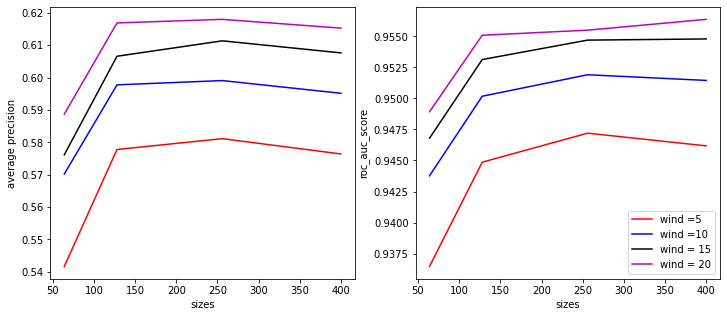

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(size, score1[5], c='r')
ax1.plot(size, score1[10], c='b')
ax1.plot(size, score1[15], c='k')
ax1.plot(size, score1[20], c='m')
ax1.set_xlabel('sizes')
ax1.set_ylabel('average precision')
ax2.legend(labels = ['wind =5','wind =10','wind = 15','wind = 20'])
ax2.plot(size, score2[5], c='r')
ax2.plot(size, score2[10], c='b')
ax2.plot(size, score2[15], c='k')
ax2.plot(size, score2[20], c='m')
ax2.set_xlabel('sizes')
ax2.set_ylabel('roc_auc_score')
ax2.legend(labels = ['wind =5','wind =10','wind = 15','wind = 20']);

In [ ]:
%%time
model_w2v = word2vec.Word2Vec(data.text_comb, size=264, window=20, min_count=5, workers=7, sg=1)
wv_train_feat, wv_test_feat, y_train, y_test = train_test_split(data.text_comb.apply(document_vector), y_binarized, test_size=0.2, random_state=42)
clf_lr = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
clf_lr.fit(list(wv_train_feat), y_train)
lr_pred = clf_lr.predict_proba(list(wv_test_feat))
df_perf = metrics_report("reg_logit_wv", y_test, lr_pred, df=None)
print(df_perf)

                     reg_logit_wv
Av_precision(macro)      0.643630
Av_precision(micro)      0.730054
ROC_AUC(macro)           0.957439
ROC_AUC(micro)           0.966306
CPU times: user 10min 50s, sys: 1min 3s, total: 11min 54s
Wall time: 6min 19s


### BERT Embedding

#### BERT hub Tensorflow

In [ ]:
!pip install transformers

In [ ]:
!pip install tensorflow_text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

In [ ]:
dt =data.copy()
dt.text_comb = dt.text_comb.apply(lambda text : " ".join(text))

In [ ]:
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2" 
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)

In [ ]:
def feature_bert_fct(sentences, key, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        inputs = preprocess(sentences[idx:idx+batch_size])
        feat = bert(inputs)[key]

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    if idx+batch_size<len(sentences):
       inputs = preprocess(sentences[idx+batch_size:len(sentences)])
       feat = bert(inputs)[key]
       features = np.concatenate((features,feat))      

    return features

In [ ]:
%%time
key='pooled_output'
reg_logit_clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
feat_bert = feature_bert_fct(dt.text_comb, key,64)
# split features
Bertfet_train, Bertfet_test, y_train, y_test = train_test_split(feat_bert, y_binarized, test_size=0.25)
reg_logit_clf.fit(Bertfet_train, y_train)
#Prediction
bert_plr = reg_logit_clf.predict_proba(Bertfet_test)
df_performance = metrics_report("reg_logit with Bert_tfh", y_test, bert_plr, df=None)
print(df_performance)

                     reg_logit with Bert_tfh
Av_precision(macro)                 0.413687
Av_precision(micro)                 0.470361
ROC_AUC(macro)                      0.885556
ROC_AUC(micro)                      0.901939
CPU times: user 10min 7s, sys: 19.6 s, total: 10min 27s
Wall time: 9min 56s


####

In [ ]:
#!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
#download a pretrained model
model_bert = SentenceTransformer('all-MiniLM-L6-v2')
#model_bert = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
def feature_bert_fct(sentences, b_size) :
    batch_size = b_size
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = model_bert.encode(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

     
    if idx+batch_size<len(sentences):
    
       features = np.concatenate(features,model_bert.encode(sentences[idx+batch_size:len(sentences)]))

    return features

In [ ]:
%%time
batch_size = 64
sentence_embeddings = model_bert.encode(dt.text_comb)

CPU times: user 9min 12s, sys: 5.74 s, total: 9min 18s
Wall time: 9min 14s


In [ ]:
%%time
# split features
Bertfet_train, Bertfet_test, y_train, y_test = train_test_split(sentence_embeddings, y_binarized, test_size=0.25)
reg_logit_clf = OneVsRestClassifier(LogisticRegression())
reg_logit_clf.fit(Bertfet_train, y_train)
#Prediction
bert_pred_lr = reg_logit_clf.predict_proba(Bertfet_test)
df_performance = metrics_report("reg_logit with use", y_test, bert_pred_lr, df=None)
print(df_performance)

                     reg_logit with use
Av_precision(macro)            0.653271
Av_precision(micro)            0.742513
ROC_AUC(macro)                 0.966892
ROC_AUC(micro)                 0.974348
CPU times: user 42 s, sys: 12.8 s, total: 54.8 s
Wall time: 42.1 s


#### USE - Universal Sentence Encoder

In [ ]:
#First download a pretrained model
Model_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE(sentences, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = Model_use(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

     
    if idx+batch_size<len(sentences):
       feat = Model_use(sentences[idx+batch_size:len(sentences)])
       features = np.concatenate((features,feat))

    return features

In [ ]:
%%time
batch_size = 64
use_features = feature_USE(dt.text_comb, batch_size)

CPU times: user 11.8 s, sys: 606 ms, total: 12.4 s
Wall time: 9.75 s


In [ ]:
%%time
# split features
usefet_train, usefet_test, y_train, y_test = train_test_split(use_features, y_binarized, test_size=0.25)
reg_logit_clf = OneVsRestClassifier(LogisticRegression())
reg_logit_clf.fit(usefet_train, y_train)
#Prediction
usepred_lr = reg_logit_clf.predict_proba(usefet_test)
df_performance = metrics_report("reg_logit with use", y_test, usepred_lr, df=None)
print(df_performance)

                     reg_logit with use
Av_precision(macro)            0.674334
Av_precision(micro)            0.747826
ROC_AUC(macro)                 0.967856
ROC_AUC(micro)                 0.974705
CPU times: user 57.1 s, sys: 15.7 s, total: 1min 12s
Wall time: 52.6 s


### Entrainement avec des approches non supervisées

Latent Dirichlet Allocation (LDA) est une technique de clustering non supervisée utilisée pour l'analyse de texte. Le nombre de sujets peut être vu comme le nombre de clusters. En faisant de la modélisation thématique, nous construisons des groupes de mots plutôt que des groupes de textes. Un texte est donc un mélange de tous les topics, chacun ayant un poids spécifique.
 
Le module *"LdaMulticore de Gensim"*  permet d'une parallélisation, on choisit celui qui possède un score de cohérence maximum suivant le nombre de topic. Le score de coherence mesure le degré de similitude sémantique des mots les plus représentés pour chaque topic.

In [12]:
import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess
from pprint import pprint
from gensim.models import CoherenceModel
# Create Dictionary
id2word = corpora.Dictionary(data.text_comb)
# Create Corpus
Texts = data.text_comb
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in Texts]
# View
print(corpus[:1])
count = 0
for tk in id2word.values():
    print(tk)
    count += 1
    if count > 10:
        break

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]]
android
array
beautify
bit
bracket
class
code
comma
console
correct
fit


In [ ]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, passes=2, iterations=25)

In [ ]:
# Print the Keyword in 5 topics
pprint(lda_model.print_topics(5))
doc_lda = lda_model[corpus]

[(7,
  '0.026*"database" + 0.015*"table" + 0.012*"data" + 0.011*"sql" + '
  '0.010*"store" + 0.009*"create" + 0.009*"mysql" + 0.009*"query" + '
  '0.009*"server" + 0.008*"code"'),
 (9,
  '0.026*"android" + 0.018*"app" + 0.012*"api" + 0.009*"user" + '
  '0.008*"application" + 0.008*"code" + 0.007*"device" + 0.006*"service" + '
  '0.006*"access" + 0.006*"client"'),
 (6,
  '0.013*"spring" + 0.011*"data" + 0.010*"view" + 0.010*"json" + 0.009*"mvc" + '
  '0.009*"asp" + 0.009*"request" + 0.009*"create" + 0.008*"controller" + '
  '0.008*"code"'),
 (2,
  '0.010*"java" + 0.009*"question" + 0.008*"difference" + 0.007*"class" + '
  '0.007*"method" + 0.006*"performance" + 0.006*"type" + 0.006*"implement" + '
  '0.006*"implementation" + 0.006*"code"'),
 (1,
  '0.009*"window" + 0.008*"file" + 0.008*"code" + 0.007*"error" + 0.007*"add" '
  '+ 0.006*"follow" + 0.006*"create" + 0.005*"application" + 0.005*"solution" '
  '+ 0.005*"event"')]


In [ ]:
#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=Texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', round(coherence_lda,4))


Coherence Score:  0.5352


In [ ]:
topics_nb = 17
# Alpha parameter
alpha = [0.01, 0.3, 0.9,'symmetric', 'asymmetric']
# Eta parameter
eta = [0.01, 0.3, 0.9,'symmetric', 'auto']
CS={}
cs=[]
for a in alpha:
   for e in eta:
     lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=topics_nb, random_state=42,
                                 passes=10, alpha=a, eta=e, workers=7)
     coherence_model_lda = CoherenceModel(model=lda_model, texts=Texts, 
                                     dictionary=id2word, coherence='c_v')
     cs.append(coherence_model_lda.get_coherence())
   CS[a] = cs
   cs=[] 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
max_0=[]
for k in range(0,len(CS.keys())):
   max_0.append(max(CS[alpha[k]]))
max_key = alpha[np.argmax(max_0)]
max_val = eta[np.argmax(CS[max_key])]

print(f'With ten topics, the coherence score is highest when alpha = {max_key} and eta = {max_val}')

With ten topics, the coherence score is highest when alpha = asymmetric and eta = symmetric


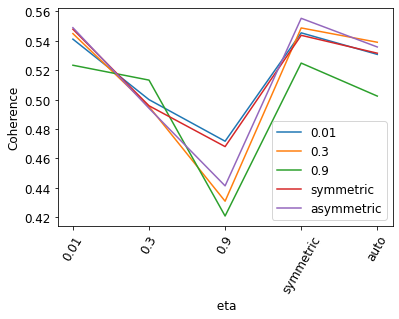

In [ ]:
fig = plt.figure()
x=range(len(eta))
for key in CS.keys():
  plt.plot(CS[key])
plt.xticks(x, eta,fontsize=12,rotation=60)
plt.yticks(fontsize=12)
plt.ylabel('Coherence',fontsize=12)
plt.xlabel(' eta',fontsize=12)
plt.legend(labels=alpha,fontsize=12)
plt.show()

In [ ]:
topics_nb = range(10,31)
# Alpha parameter
alpha = ['symmetric', 'asymmetric']
# Eta parameter
eta = ['symmetric', 'auto']
CS={}
cs={}
csn=[]
for a in alpha:
   for e in eta:
     for k in topics_nb:
        lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k, random_state=42,
                                 passes=10, alpha=a, eta=e,workers=7)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=Texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
        csn.append(coherence_model_lda.get_coherence())
     cs[e] = csn
     csn=[]
   CS[a] = cs 
   cs={}

In [ ]:
opt={}
for a in alpha:
  opt[a]=max(CS[a])
K = list(opt.keys())
if max(CS[K[0]][opt[K[0]]]) < max(CS[K[1]][opt[K[1]]]):
  alpha_opt = K[1]
  eta_opt = opt[K[1]]
else:
  alpha_opt = K[0]
  eta_opt = opt[K[0]]

nb_opt = topics_nb[np.argmax(CS['asymmetric']['symmetric'])]
CS_opt = max(CS['asymmetric']['symmetric'])
print(f"We get the highest coherence score {CS_opt}, when:\n alpha = '{alpha_opt}', eta = '{eta_opt}' and number of topics equals {nb_opt}.")  


We get the highest coherence score 0.5551661808395734, when:
 alpha = 'asymmetric', eta = 'symmetric' and number of topics equals 17


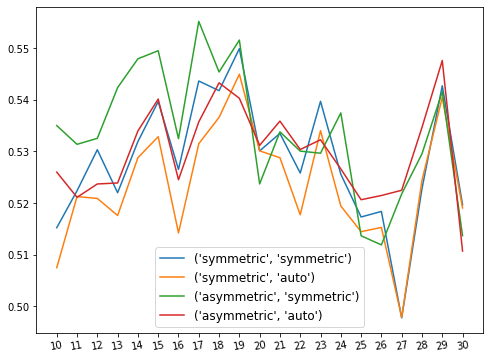

In [ ]:
fig = plt.figure(figsize=(8, 6))
topics_nb = range(10,31)
leg=[]
for k0 in CS.keys():
  for k1 in CS[k0].keys():
     plt.plot(topics_nb,CS[k0][k1])
     leg.append((k0, k1))
plt.xticks(topics_nb, topics_nb,rotation=10)
plt.legend(leg,fontsize=12);

In [ ]:
pip install pyLDAvis

On visualise les résultats à l'aide du package pyLDAvis. les sujets sont représentés avec des cercles dont la taille est lié à la popularité du sujet.
Un bon modèle de sujet aura de grands cercles non superposés dispersés dans tout le graphique

Sur le côté droit, les mots-clés les plus pertinents du sujet sélectionné.

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# train the model with optimal parameters
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=nb_opt, random_state=42,
                                passes=10, alpha=alpha_opt, eta=eta_opt)

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds='mmds',R=20)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.217563  0.001431       1        1  11.388102
0      0.012170  0.097597       2        1  10.308232
4      0.273228 -0.121156       3        1   9.887811
10    -0.045191  0.194857       4        1   9.590893
2      0.225912  0.146116       5        1   8.536407
1     -0.078022 -0.068451       6        1   7.629048
9      0.065722 -0.097957       7        1   7.377199
11     0.253496 -0.247426       8        1   5.843567
5     -0.071780  0.320553       9        1   5.381102
8      0.370976  0.102546      10        1   4.654164
12     0.106956  0.321634      11        1   4.590644
14    -0.236140  0.235587      12        1   3.914153
7     -0.250245 -0.062920      13        1   3.093042
3      0.058014 -0.349757      14        1   2.991446
16    -0.096366 -0.329185      15        1   2.730184
13    -0.366032 -0.228130      16        1   1.072606
15    -0.440261  0.084660      17        1   1.011399, topic_info=         Term         Freq        Total Category  logprob  loglift
33       file  4896.000000  4896.000000  Default  20.0000  20.0000
101     image  1912.000000  1912.000000  Default  19.0000  19.0000
363    python  2434.000000  2434.000000  Default  18.0000  18.0000
447    string  1925.000000  1925.000000  Default  17.0000  17.0000
309    spring   984.000000   984.000000  Default  16.0000  16.0000
...       ...          ...          ...      ...      ...      ...
429    public    62.759504   235.222050  Topic17  -4.6413   3.2726
2587  restore    30.050910    69.804628  Topic17  -5.3777   3.7510
8325  openssl    30.146047    78.030638  Topic17  -5.3745   3.6428
254      time    68.509697  2900.430849  Topic17  -4.5536   0.8482
2966    plist    25.935503    80.498084  Topic17  -5.5249   3.4612

[826 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4914     13  0.986183      aar
256       1  0.438141   access
256       2  0.139678   access
256       3  0.013836   access
256       4  0.004612   access
...     ...       ...      ...
312      15  0.216065      xml
312      17  0.020653      xml
1144      1  0.025662  youtube
1144      5  0.966596  youtube
4764      2  0.984851   zipped

[2490 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 5, 11, 3, 2, 10, 12, 6, 9, 13, 15, 8, 4, 17, 14, 16])

##### Distribution des thèmes pour chaque documents

In [ ]:
# obtain topic distributions for each document
topic_dist = pd.DataFrame(lda_model.get_document_topics(corpus, minimum_probability=0.0))
for topic in topic_dist.columns:
    topic_dist[topic] = topic_dist[topic].apply(lambda x : x[1])

print('document/topic : ', topic_dist.shape)

document/topic :  (19117, 17)


In [ ]:
topic_dist.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.004013,0.314442,0.173258,0.002311,0.002026,0.435948,0.001626,0.001480,0.001358,0.001254,0.001165,0.056551,0.001021,0.000961,0.000908,0.000861,0.000818
1,0.311778,0.010225,0.008552,0.007352,0.006447,0.005740,0.005173,0.004708,0.004319,0.003990,0.003708,0.509207,0.003248,0.003058,0.107154,0.002738,0.002602
2,0.200051,0.183954,0.002240,0.001925,0.001688,0.001503,0.430890,0.070252,0.067612,0.001045,0.000971,0.000907,0.000851,0.000801,0.033910,0.000717,0.000682
3,0.054119,0.004331,0.180924,0.003110,0.335348,0.193468,0.002189,0.001992,0.213647,0.001688,0.001569,0.001465,0.001374,0.001294,0.001222,0.001159,0.001101
4,0.388849,0.005355,0.204353,0.312746,0.003377,0.003007,0.002710,0.002466,0.002263,0.002090,0.001942,0.001814,0.063116,0.001602,0.001514,0.001434,0.001363


In [ ]:
print(lda_model.get_term_topics('java', minimum_probability=0.01))
print(lda_model.get_term_topics('http', minimum_probability=0.01))
print(lda_model.get_term_topics('image', minimum_probability=0.01))

[(16, 0.019719975)]
[(6, 0.017490085)]
[(2, 0.017995501), (3, 0.04470643)]


Nous allons utiliser des distributions des thèmes obtenus par le modèle LDA comme des features pour le modèle d'une régression logistique. Dans le bus de caractériser la qualité des ces features.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(topic_dist, y_binarized, test_size=0.25, random_state=100)
lr = OneVsRestClassifier(LogisticRegression()).fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_test)
df_LDA_lr = metrics_report("LDA_lr", y_test, y_pred_lr, df=None)
print(df_LDA_lr)

                       LDA_lr
Av_precision(macro)  0.154347
Av_precision(micro)  0.207424
ROC_AUC(macro)       0.819565
ROC_AUC(micro)       0.849681


##### Modèle NMF

In [ ]:
from sklearn.decomposition import NMF
# Create an NMF  model

model_nmf = NMF(n_components= 17, init='random', random_state=5, max_iter=500)
 
# Fit the model to TF-IDF
model_nmf.fit(X_tfidf)
 
# Transform the TF-IDF: nmf_features
nmf_features = model_nmf.transform(X_tfidf)

In [ ]:
print(X_tfidf.shape)
print(nmf_features.shape)
print(model_nmf.components_.shape)

(19117, 6616)
(19117, 17)
(17, 6616)


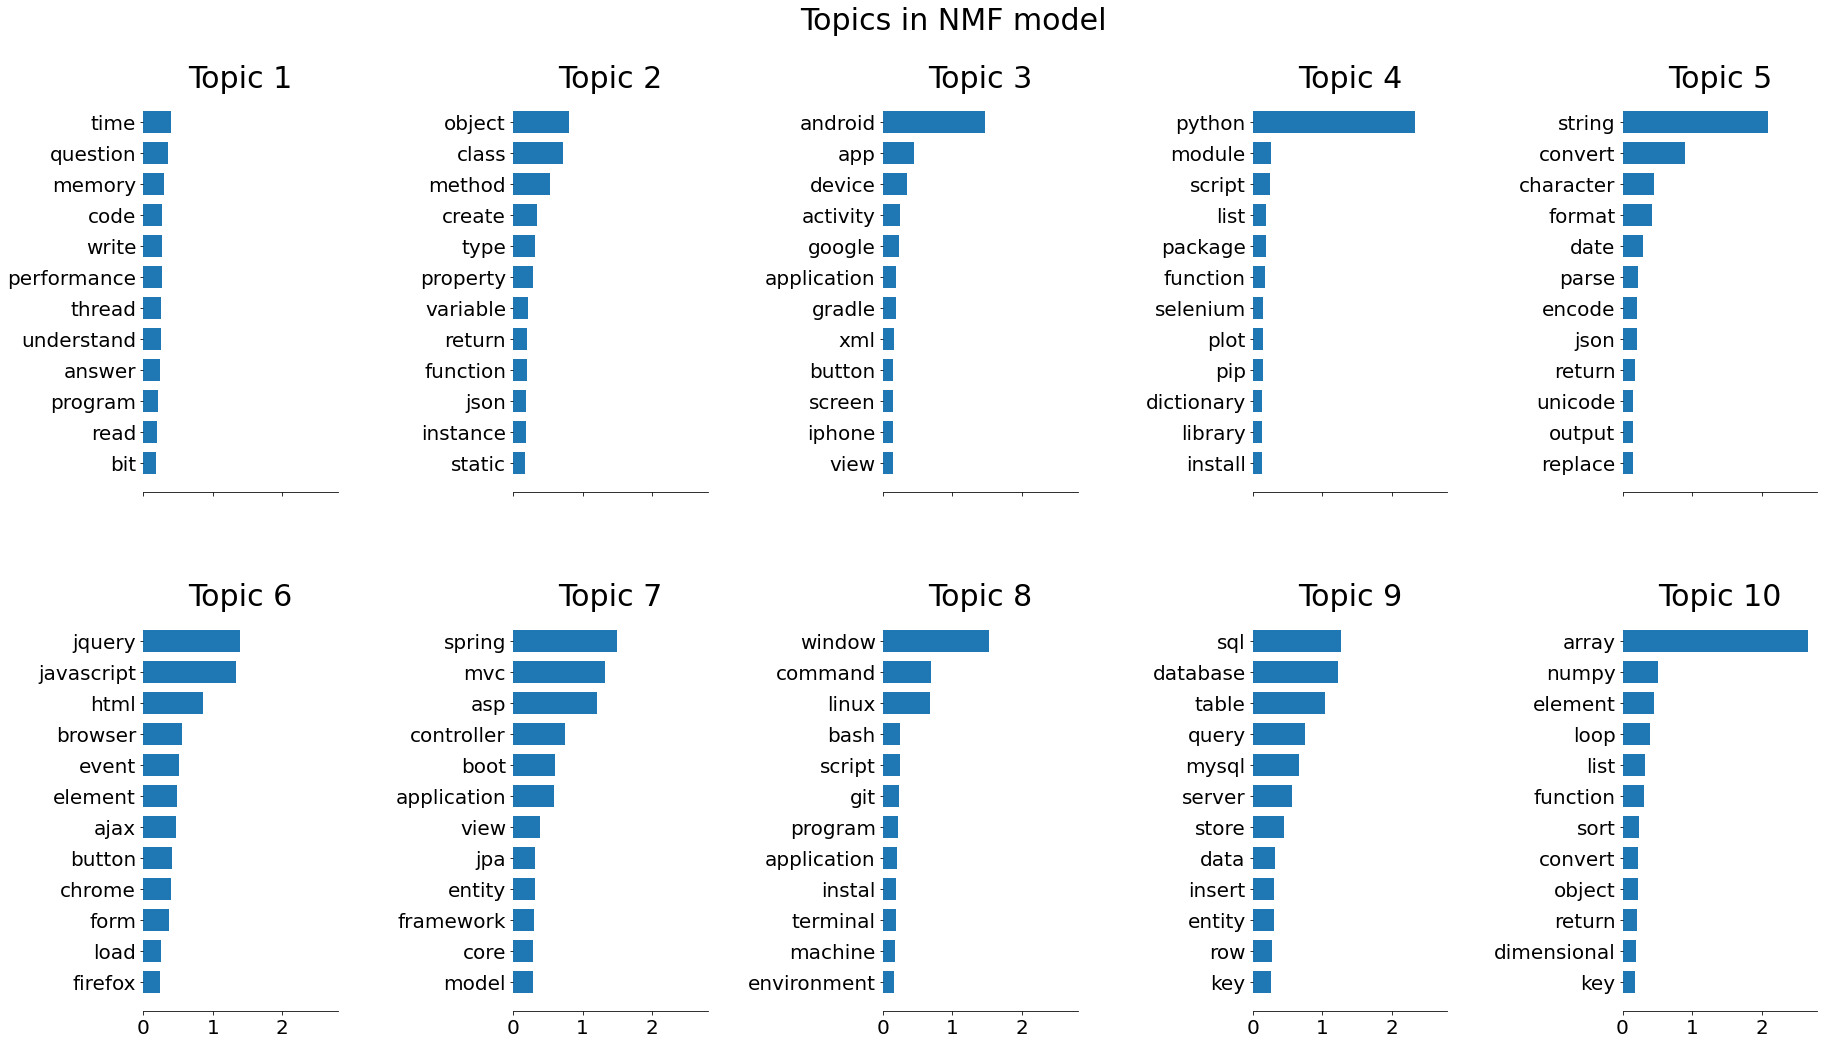

In [ ]:
# Plot the 10 first topics
n_top_words =12
feature_names = vectorizer.get_feature_names()
fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(model_nmf.components_):
  if(topic_idx < 10):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Topics in NMF model', fontsize=30)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.show()

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].


SyntaxError: ignored

In [ ]:
pip install transformers

In [ ]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

ImportError: ignored